In [11]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Evolutionary
using Random
using BlackBoxOptim

In [12]:
include("unicycle_env.jl")
include("controller.jl")
include("safe_set.jl")
include("problem.jl")

costs (generic function with 1 method)

In [13]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [14]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = [0, 1.5]
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function tracking(rp::RP, ctrl; fps=10, tf=2, obstacles=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    col_cnt = 0
    infeas=false
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=obstacles, safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
            return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
        if norm(x[1:2] - rp.xg[1:2]) < 0.1
            return X[1:i+1], U[1:i], safe_sets[1:i], Xrefs[1:i], infeas
        end
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

function following(rp::RP, ctrl; fps=10, tf=2, targets=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    infeas=false
    for i in 1:T-1
        xg = [targets[i].center..., norm(targets[i].vel), 0]
        @show
        Xref = get_Xref(x, xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=[targets[i]], safety_index=safety_index)
        u, safe_set = timed_result.value
        dot_x = compute_output(net, [x; u])
        if !(dot_x ∈ safe_set)
            infeas=true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(safety_index, x, targets[i])
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

following (generic function with 1 method)

In [15]:
Random.seed!(1)
n = 1
obstacles0 = [Obstacle([0.2, 2], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.0, 1e-3, 1, 0)

Xexec0, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles0, safety_index=ci, verbose=false);

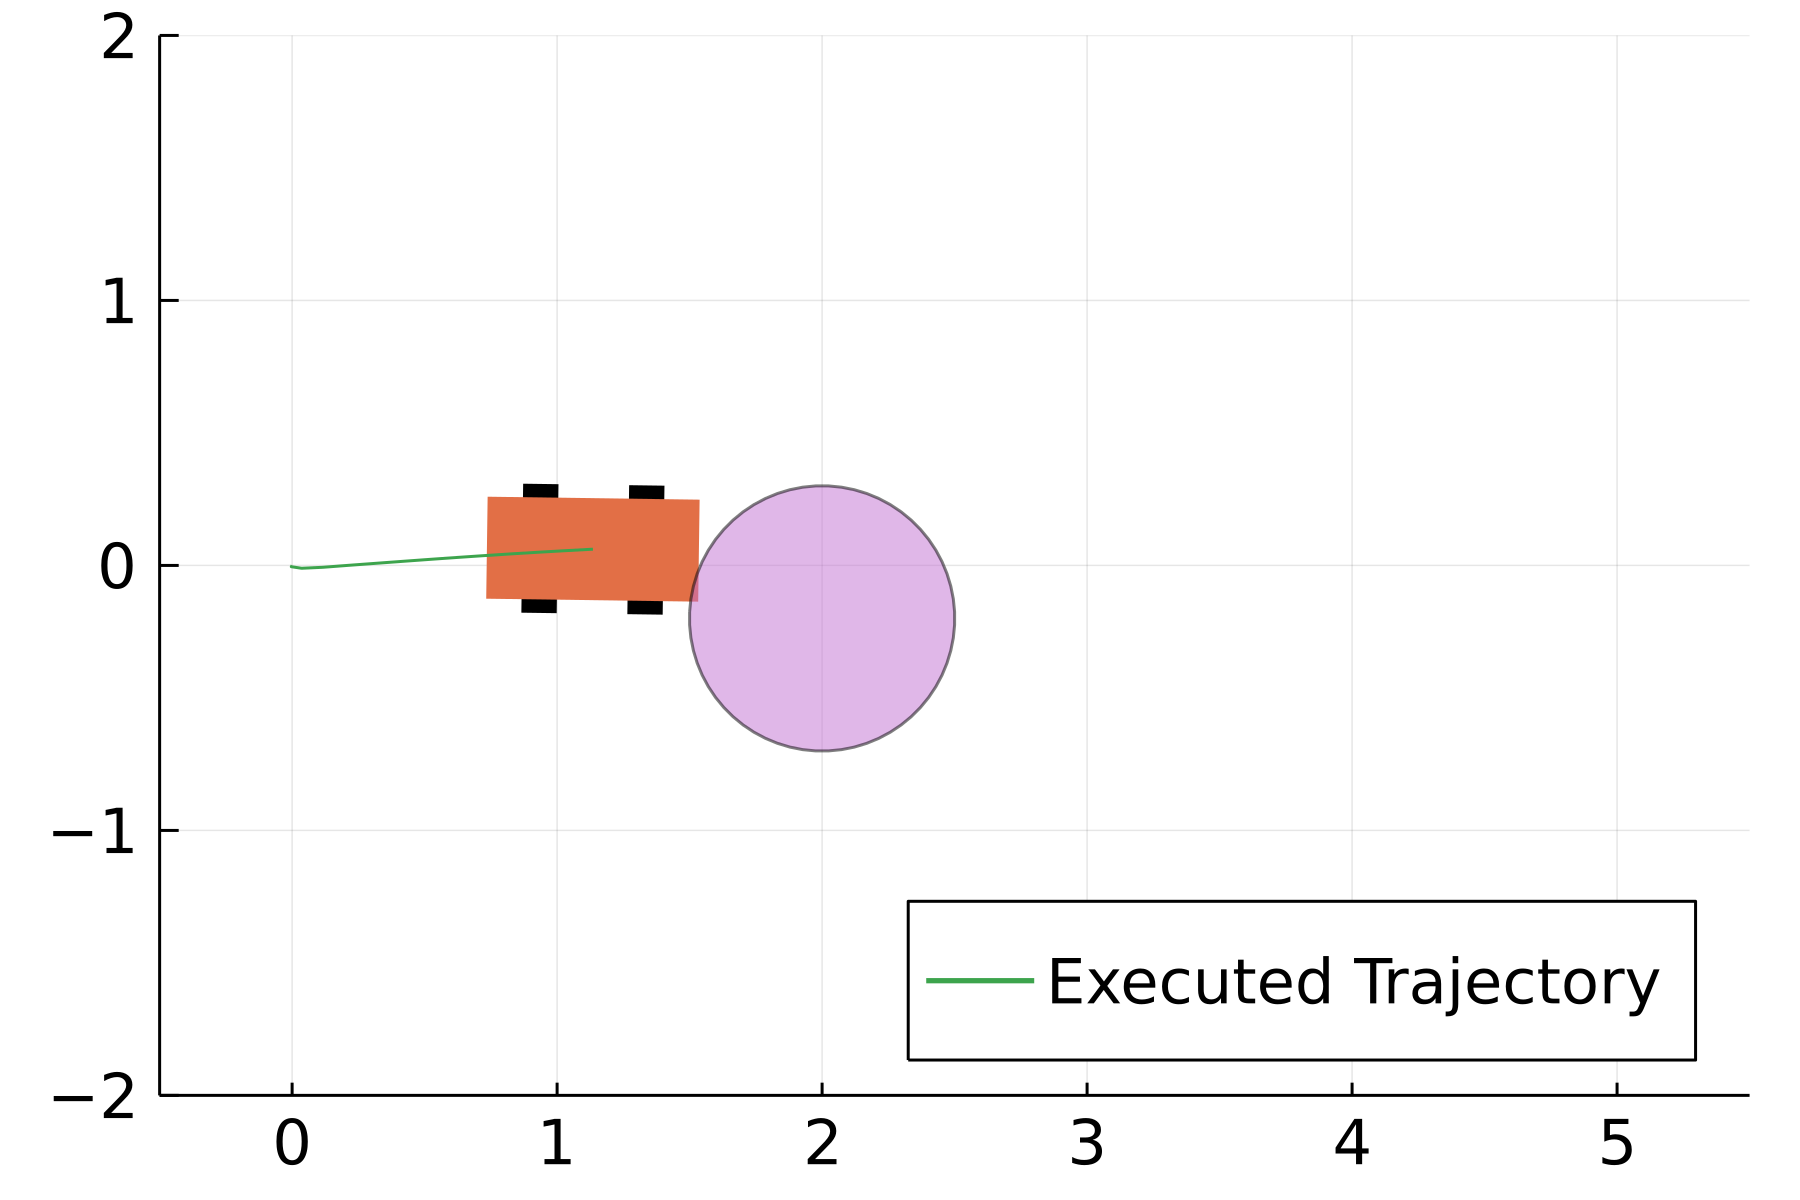

true

In [16]:
include("unicycle_env.jl")
XX = [[x[2], -x[1], x[3], x[4]-pi/2] for x in Xexec0]
XX = XX[1:end-3]
OO = [Obstacle([x.center[2], -x.center[1]], x.vel, x.radius) for x in obstacles0]
visualize(XX, obstacles=OO, xlims=[-0.5,5.5], ylims=[-2,2], fps=100, save_frame=(length(XX)-1, "../results/phi_collision_0.png"))

In [7]:
Random.seed!(1)
n = 1
obstacles1 = [Obstacle([0.2, 2], [0,0], obs_radius)]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)
err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.243861, 5.0, 1.58716, 2.07519)
Xexec1, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles1, safety_index=ci, verbose=false);

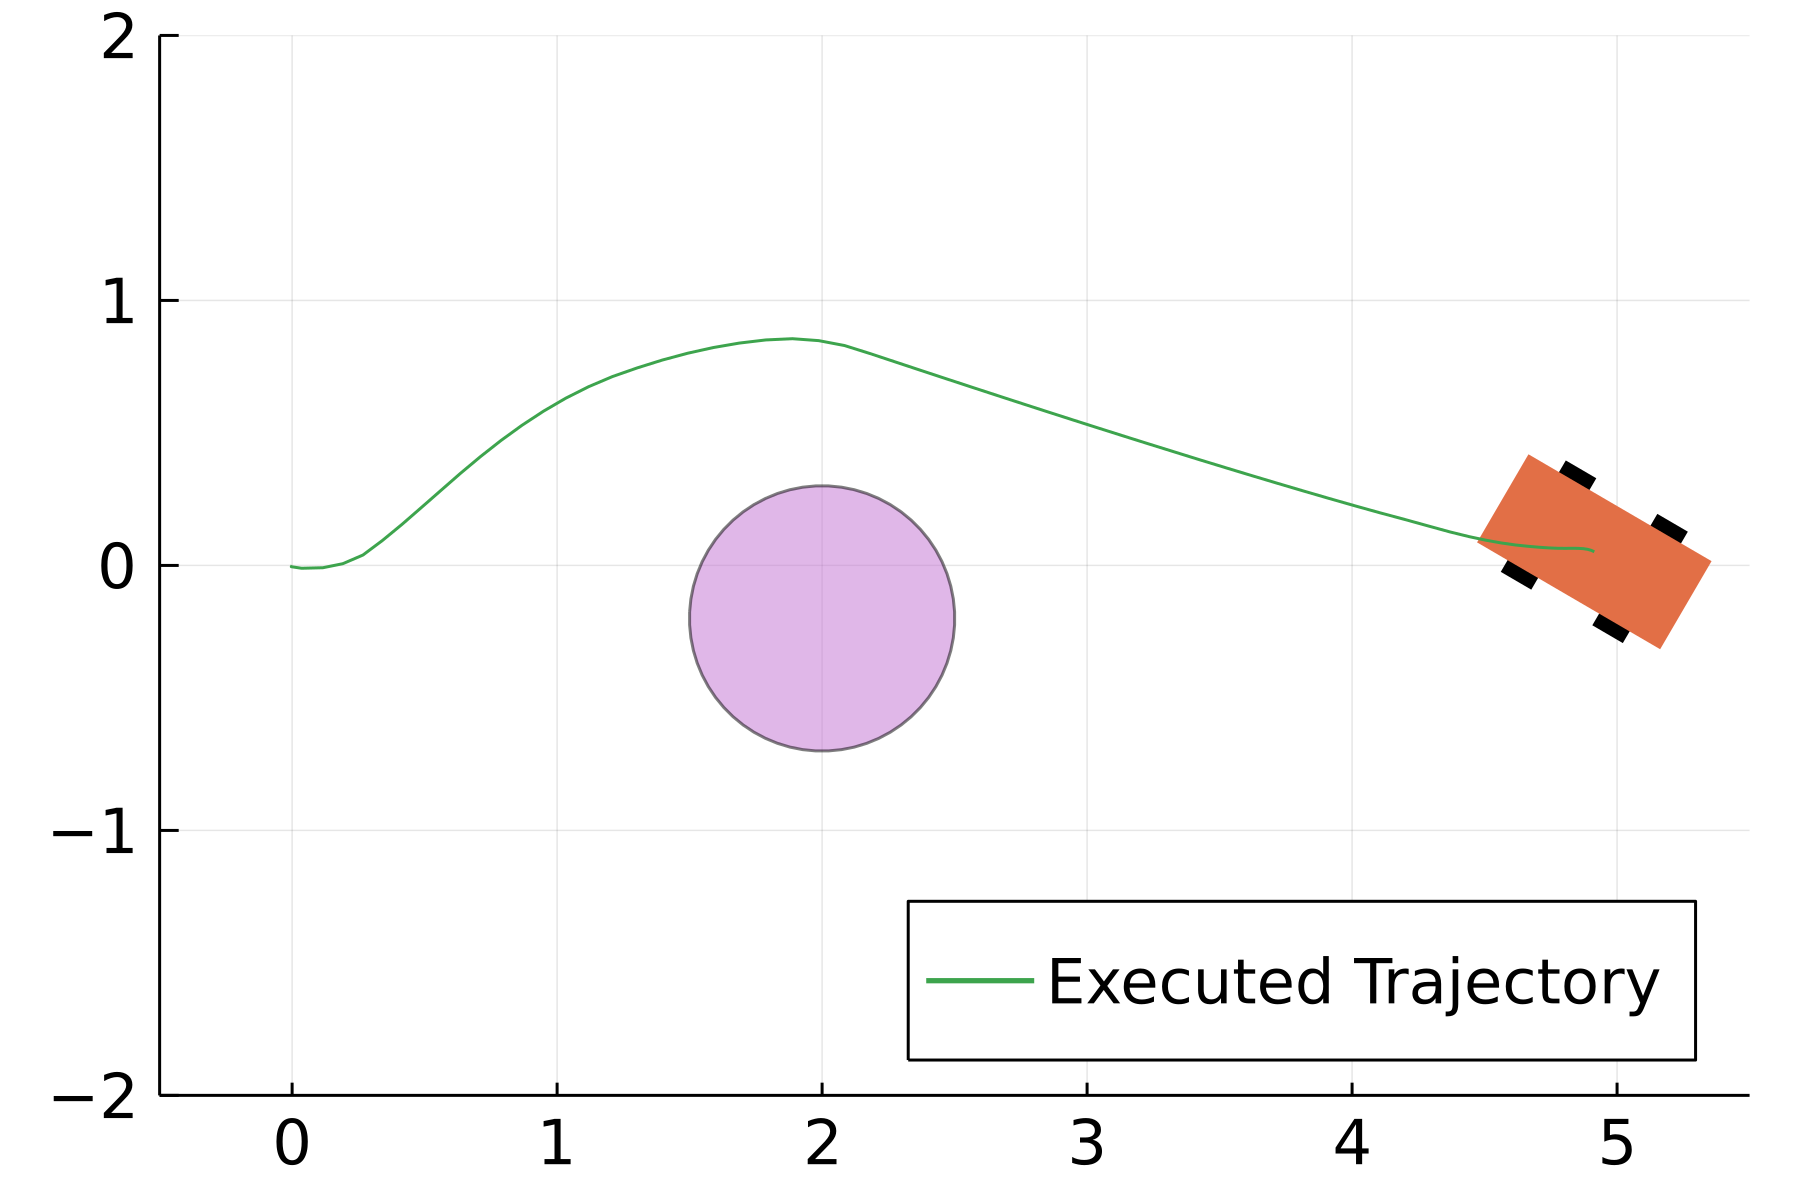

true

In [8]:
XX = [[x[2], -x[1], x[3], x[4]-pi/2] for x in Xexec1]
OO = [Obstacle([x.center[2], -x.center[1]], x.vel, x.radius) for x in obstacles1]
visualize(XX, obstacles=OO, xlims=[-0.5,5.5], ylims=[-2,2], fps=100, save_frame=(length(XX)-1, "../results/phi_collision_1.png"))

In [9]:
Random.seed!(5)
n = 2
obstacles2 = [Obstacle([x, y], [0,0], obs_radius) for (x,y) in [(0.5,1.2), (-1.4,2), (-0.3,3)]]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.243861, 5.0, 1.58716, 2.07519)
Xexec2, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=100, obstacles=obstacles2, safety_index=ci, verbose=false);

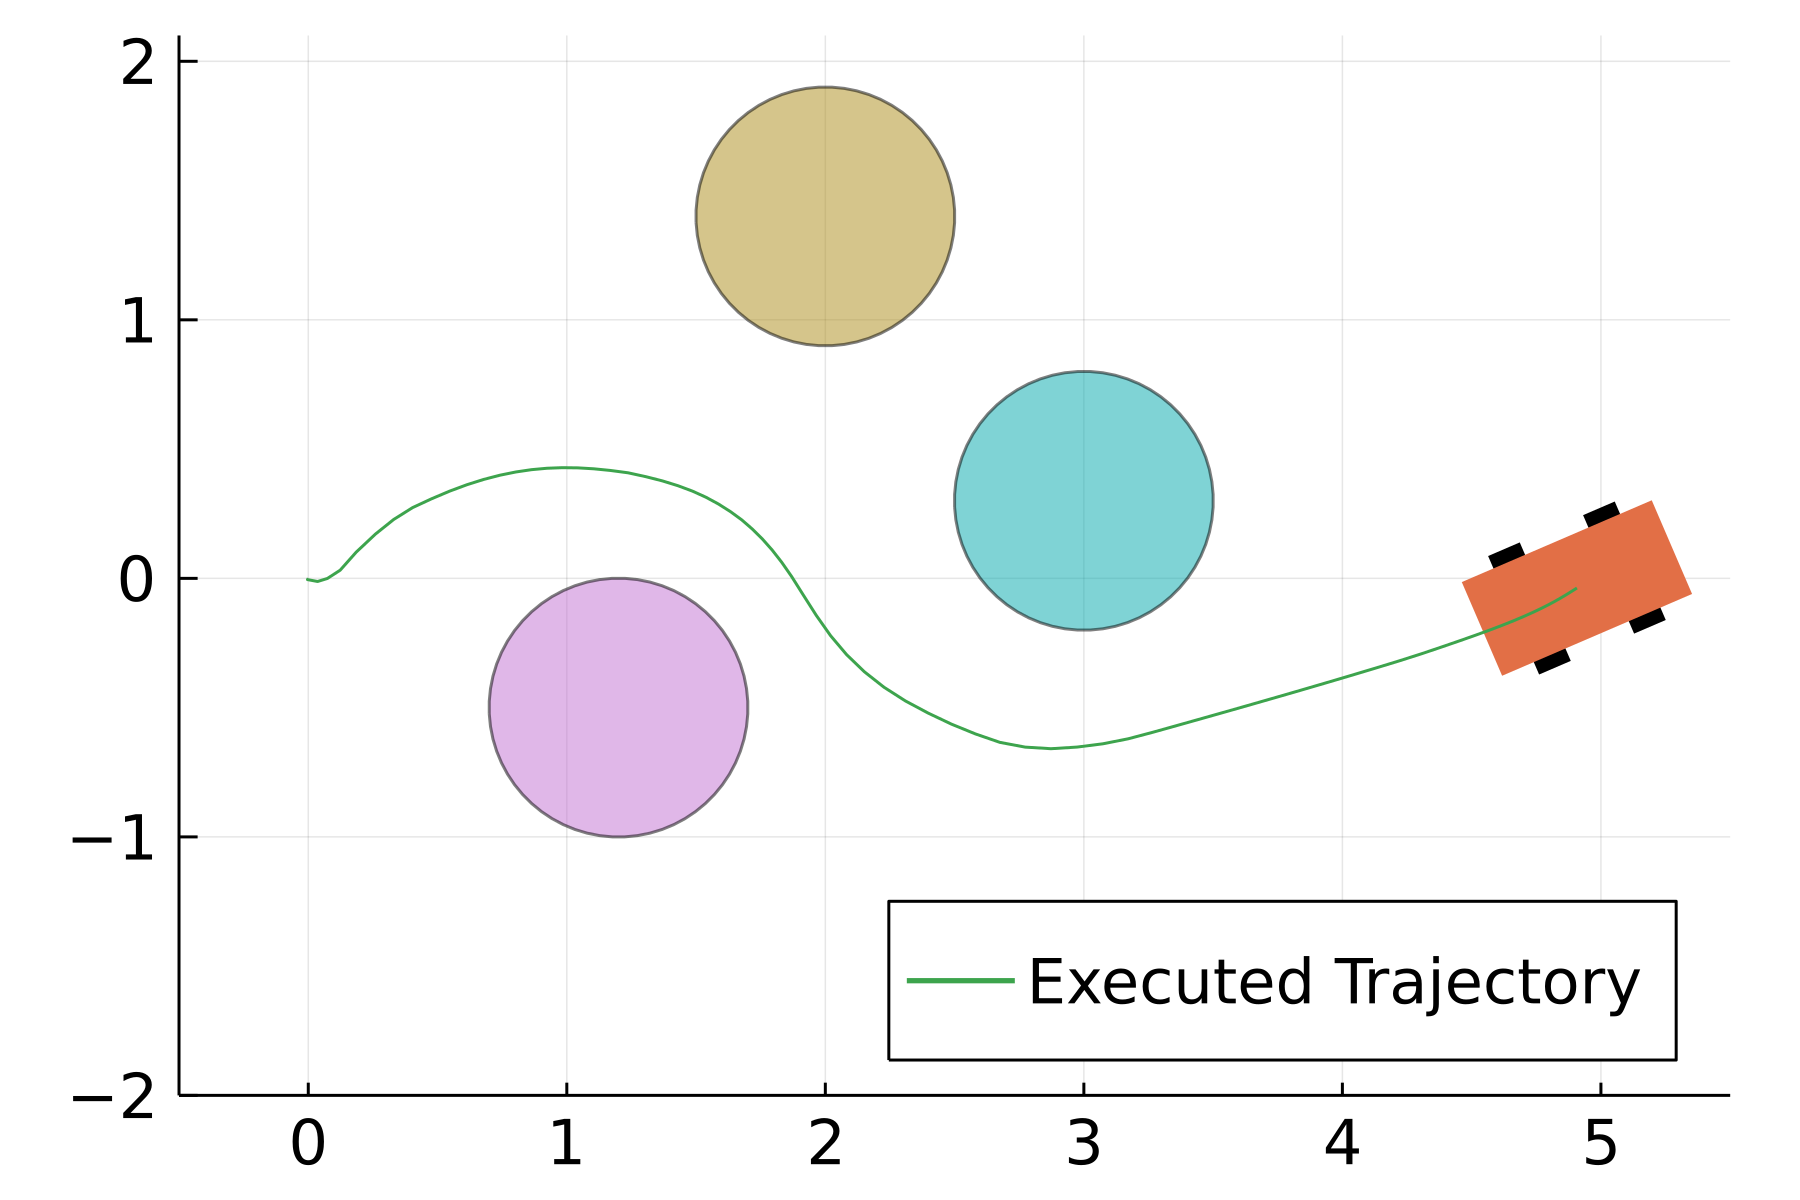

true

In [10]:
XX = [[x[2], -x[1], x[3], x[4]-pi/2] for x in Xexec2]
OO = [Obstacle([x.center[2], -x.center[1]], x.vel, x.radius) for x in obstacles2]
visualize(XX, obstacles=OO, xlims=[-0.5,5.5], ylims=[-2,2], fps=100, save_frame=(length(Xexec2)-1, "../results/phi_collision_2.png"))